# Fase 3: Implementación del Control Adelanto-Atraso y Realimentación de estados

### Funcion de transferencia

Función de transferencia G(s):
<TransferFunction>: sys[49]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


           0.01
---------------------------
0.005 s^2 + 0.06 s + 0.1001



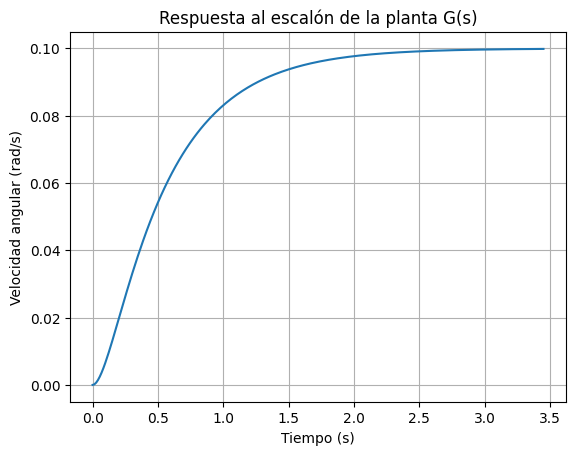

In [61]:
import control as ctrl
import matplotlib.pyplot as plt

# Parámetros físicos
J = 0.01
b = 0.1
Kt = 0.01
Ke = 0.01
R = 1
L = 0.5

# Coeficientes del denominador
num = [Kt]
den = [J*L, J*R + L*b, b*R + Kt*Ke]

# Crear la función de transferencia
G = ctrl.TransferFunction(num, den)
print("Función de transferencia G(s):")
print(G)

# Respuesta al escalón
t, y = ctrl.step_response(G)
plt.plot(t, y)
plt.title("Respuesta al escalón de la planta G(s)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad angular (rad/s)")
plt.grid(True)
plt.show()


### Modelo de espacio de estados

Sistema en espacio de estados:
<StateSpace>: sys[52]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[-10.     1.  ]
     [ -0.02  -2.  ]]

B = [[0.]
     [2.]]

C = [[1. 0.]]

D = [[0.]]



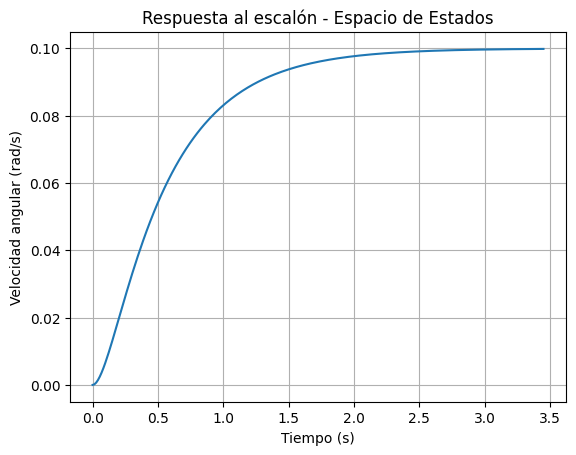

In [62]:
import numpy as np

# Matrices del sistema
A = np.array([[-b/J,    Kt/J],
              [-Ke/L,  -R/L]])

B = np.array([[0],
              [1/L]])

C = np.array([[1, 0]])
D = np.array([[0]])

# Crear el sistema en espacio de estados
sys_ss = ctrl.ss(A, B, C, D)
print("Sistema en espacio de estados:")
print(sys_ss)

# Respuesta al escalón
t, y = ctrl.step_response(sys_ss)
plt.plot(t, y)
plt.title("Respuesta al escalón - Espacio de Estados")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad angular (rad/s)")
plt.grid(True)
plt.show()


### Identificacion experimental del modelo

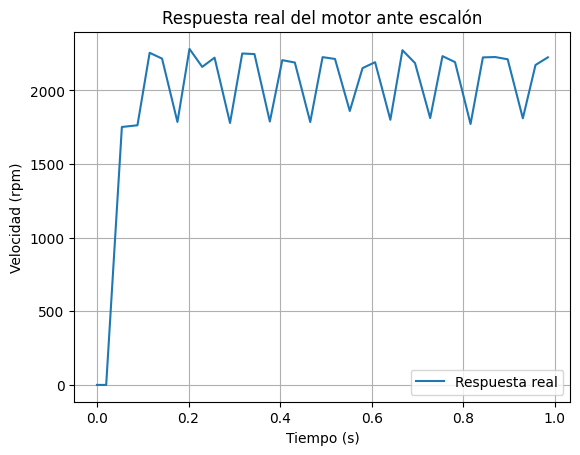

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos reales
df = pd.read_csv("datos_rpm.csv")

# Filtrar segmento donde se aplicó un escalón (puedes ajustar el rango)
# Por ejemplo, del segundo 0.5 al 2.5
df_seg = df[(df['time'] > 1.48) & (df['time'] < 2.5)].copy()
t = df_seg['time'].values - df_seg['time'].values[0]  # reiniciar tiempo desde 0
y = df_seg['rpm'].values

# Graficar la respuesta real
plt.plot(t, y, label='Respuesta real')
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (rpm)")
plt.title("Respuesta real del motor ante escalón")
plt.grid(True)
plt.legend()
plt.show()


### Ajustar Modelo de segundo Orden

Modelo ajustado:
 K = 2084.9898, wn = 35.3737, zeta = 0.7204


C:\Users\Miguel\AppData\Local\Temp\ipykernel_24236\2077855774.py:5: RuntimeWarning: invalid value encountered in sqrt
  wd = wn * np.sqrt(1 - zeta**2)


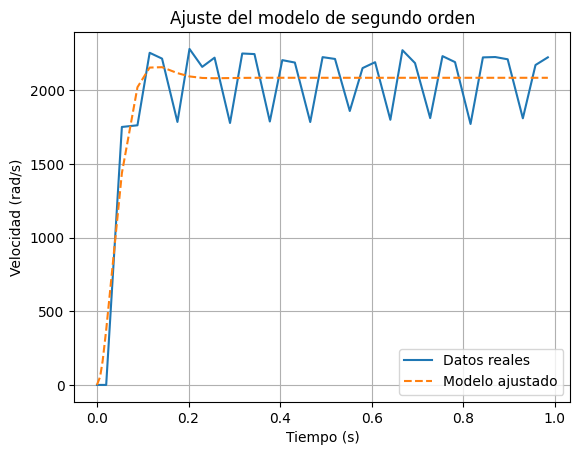

In [64]:
import numpy as np
from scipy.optimize import curve_fit

def second_order_step(t, K, wn, zeta):
    wd = wn * np.sqrt(1 - zeta**2)
    response = K * (1 - np.exp(-zeta*wn*t) * (
        np.cos(wd*t) + (zeta*wn/wd)*np.sin(wd*t)
    ))
    return response

# Estimar parámetros iniciales (puedes afinar)
K0 = y[-1]
wn0 = 10
zeta0 = 0.7
p0 = [K0, wn0, zeta0]

# Ajustar curva
params, _ = curve_fit(second_order_step, t, y, p0)
K_est, wn_est, zeta_est = params
print(f"Modelo ajustado:\n K = {K_est:.4f}, wn = {wn_est:.4f}, zeta = {zeta_est:.4f}")

# Graficar resultado
y_fit = second_order_step(t, *params)
plt.plot(t, y, label='Datos reales')
plt.plot(t, y_fit, '--', label='Modelo ajustado')
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (rad/s)")
plt.title("Ajuste del modelo de segundo orden")
plt.grid(True)
plt.legend()
plt.show()


### Convertir a funcion de transferencia

G(s) estimada:
<TransferFunction>: sys[53]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     2.609e+06
--------------------
s^2 + 50.97 s + 1251



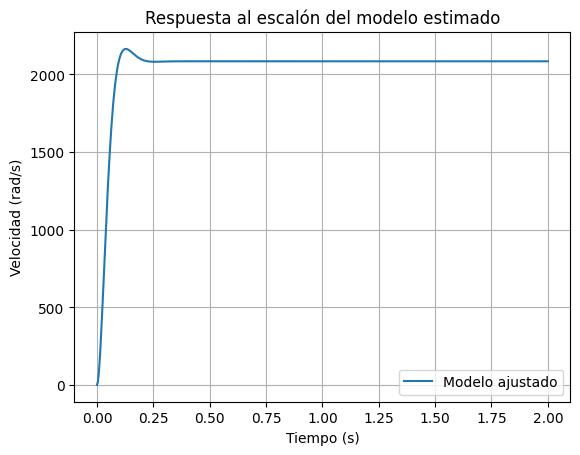

In [65]:
from control import TransferFunction

# Numerador y denominador según fórmula estándar
K_est, wn_est, zeta_est
num = [K_est * wn_est**2]
den = [1, 2*zeta_est*wn_est, wn_est**2]

# Crear la función de transferencia
G_fit = TransferFunction(num, den)

# Mostrar la función de transferencia
print("G(s) estimada:")
print(G_fit)
t = np.linspace(0, 2, 500)
t_out, y_out = ctrl.step_response(G_fit, T=t)

plt.plot(t_out, y_out, label='Modelo ajustado')
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (rad/s)")
plt.title("Respuesta al escalón del modelo estimado")
plt.grid(True)
plt.legend()
plt.show()


### Diseño Controlador

In [66]:
import control as ctrl
import matplotlib.pyplot as plt

# Planta ajustada
K, wn, zeta = K_est, wn_est, zeta_est
num = [K * wn**2]
den = [1, 2*zeta*wn, wn**2]
G = ctrl.TransferFunction(num, den)


### Caracteristicas deseadas

- Tiempo de establecimiento $ (t_s)=0.5 $ s
- Sobreimpulso $ (M_p) < 10 $ %

Coeficiente de amortiguamiento ζ = 0.5912
Frecuencia natural ω_n = 16.9160 rad/s
Polos dominantes deseados:
s1 = -10.00 + j13.64
s2 = -10.00 - j13.64


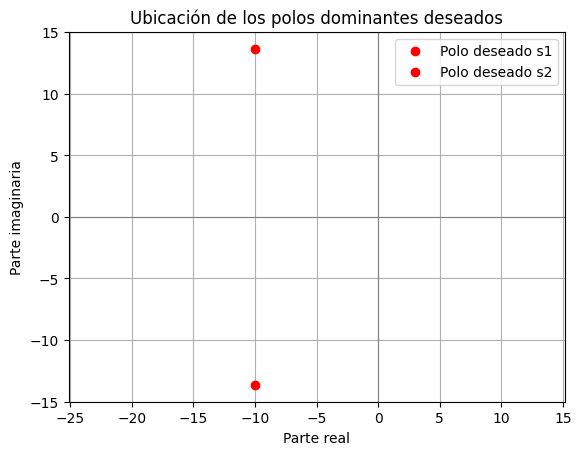

In [67]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# === 1. Especificaciones deseadas ===
OS = 10        # Sobreimpulso (%)
Ts = 0.4       # Tiempo de establecimiento (s)

# === 2. Calcular zeta (amortiguamiento) a partir de OS ===
def ecuacion_zeta(zeta):
    return 100 * np.exp(-np.pi * zeta / np.sqrt(1 - zeta**2)) - OS

zeta_ini = 0.5
zeta = fsolve(ecuacion_zeta, zeta_ini)[0]
print(f"Coeficiente de amortiguamiento ζ = {zeta:.4f}")

# === 3. Calcular omega_n (frecuencia natural) a partir de Ts ===
omega_n = 4 / (zeta * Ts)
print(f"Frecuencia natural ω_n = {omega_n:.4f} rad/s")

# === 4. Calcular polos dominantes deseados ===
real_part = -zeta * omega_n
imag_part = omega_n * np.sqrt(1 - zeta**2)

print(f"Polos dominantes deseados:")
print(f"s1 = {real_part:.2f} + j{imag_part:.2f}")
print(f"s2 = {real_part:.2f} - j{imag_part:.2f}")

# === 5. Graficar los polos ===
plt.axhline(0, color='gray', linewidth=0.8)
plt.axvline(0, color='gray', linewidth=0.8)
plt.plot(real_part, imag_part, 'ro', label='Polo deseado s1')
plt.plot(real_part, -imag_part, 'ro', label='Polo deseado s2')
plt.title("Ubicación de los polos dominantes deseados")
plt.xlabel("Parte real")
plt.ylabel("Parte imaginaria")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()


In [68]:
import numpy as np
from scipy.optimize import minimize
from numpy import angle, abs, pi


# Polo deseado
s_d = -10 + 13.6j
def G(s):
    num = K * wn**2
    den = s**2 + 2*zeta*wn*s + wn**2
    return num / den
def condiciones(x):
    z, p, Kc = x
    num_c = s_d + z
    den_c = s_d + p
    C = num_c / den_c

    L = C * G(s_d)

    fase_total = angle(L)
    modulo_total = abs(L)

    fase_error = (fase_total + pi) % (2*pi) - pi
    modulo_error = Kc * modulo_total - 1

    return fase_error**2 + modulo_error**2

x0 = [5.0, 30.0, 0.05]
bounds = [(0.01, 100), (0.01, 200), (0.001, 10)]

resultado = minimize(condiciones, x0, bounds=bounds)

z_opt, p_opt, Kc_opt = resultado.x

print("Parámetros óptimos del compensador adelanto–atraso:")
print(f"  z  = {z_opt:.4f}")
print(f"  p  = {p_opt:.4f}")
print(f"  Kc = {Kc_opt:.4f}")

Parámetros óptimos del compensador adelanto–atraso:
  z  = 38.2172
  p  = 200.0000
  Kc = 0.0019


### Simular la respuesta

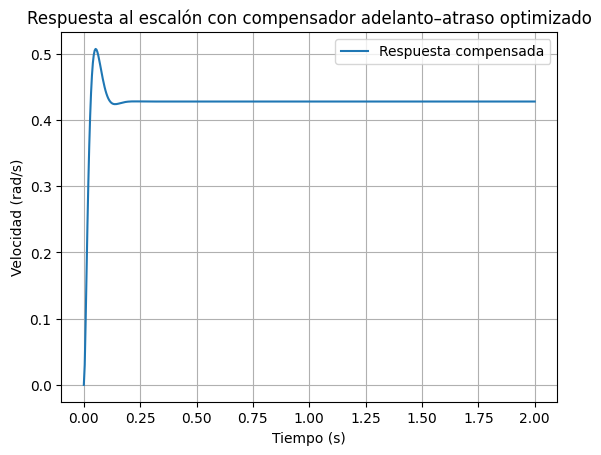

In [69]:
import control as ctrl

num_G = [K * wn**2]
den_G = [1, 2*zeta*wn, wn**2]
G = ctrl.TransferFunction(num_G, den_G)

# Compensador adelanto–atraso óptimo
z = z_opt
p = p_opt
Kc = Kc_opt

num_C = [1, z]
den_C = [1, p]
C = ctrl.TransferFunction(num_C, den_C)
# Sistema compensado
L = Kc * C * G

# Lazo cerrado unitario
T = ctrl.feedback(L)

import matplotlib.pyplot as plt
import numpy as np

# Simulación
t = np.linspace(0, 2, 500)
t_out, y_out = ctrl.step_response(T, T=t)

# Graficar
plt.plot(t_out, y_out, label='Respuesta compensada')
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (rad/s)")
plt.title("Respuesta al escalón con compensador adelanto–atraso optimizado")
plt.grid(True)
plt.legend()
plt.show()

### Controlador por realimentacion de estados

In [70]:
# Matrices en espacio de estados
A = np.array([[0, 1],
              [-wn**2, -2*zeta*wn]])

B = np.array([[0],
              [K * wn**2]])

C = np.array([[1, 0]])
D = np.array([[0]])

# Sistema en espacio de estados
sys_ss = ctrl.ss(A, B, C, D)

p_deseados = [-10 + 13.64j, -10 - 13.64j]

# Cálculo de ganancia K usando colocación de polos
K_feedback = ctrl.place(A, B, p_deseados)
print("Ganancia de realimentación de estados K:")
print(K_feedback)



Ganancia de realimentación de estados K:
[[-3.69976529e-04 -8.36456295e-06]]


### Simulacion de respuesta

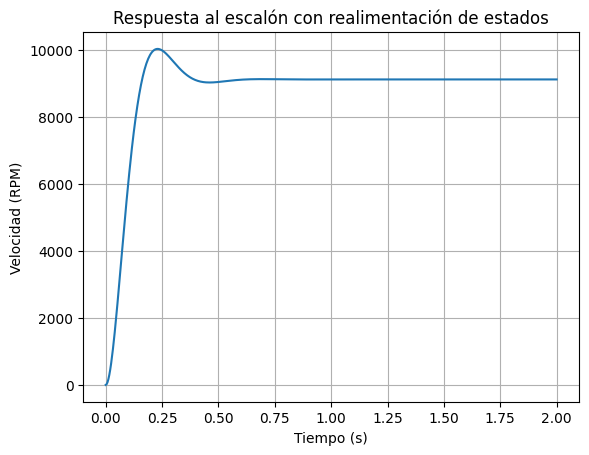

In [71]:
# Sistema en lazo cerrado: A_cl = A - B*K
A_cl = A - B @ K_feedback
sys_cl = ctrl.ss(A_cl, B, C, D)

# Simulación
t = np.linspace(0, 2, 500)
t_out, y_out = ctrl.step_response(sys_cl, T=t)

import matplotlib.pyplot as plt

plt.plot(t_out, y_out)
plt.title("Respuesta al escalón con realimentación de estados")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (RPM)")
plt.grid(True)
plt.show()


### Simulacion Con perturbacion

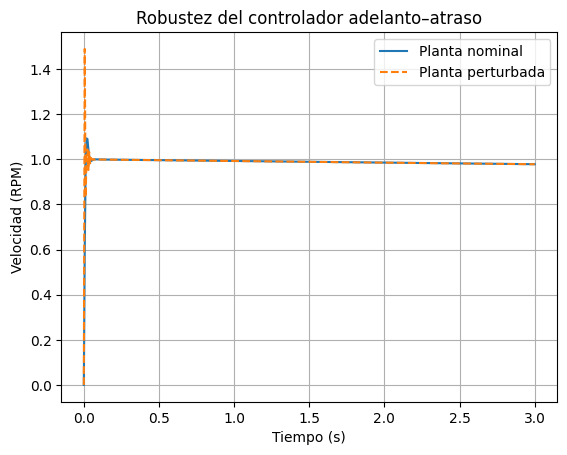

In [74]:
num_G = [K * wn**2]
den_G = [1, 2*zeta*wn, wn**2]
G_rpm = ctrl.TransferFunction(num_G, den_G)

# --- Controlador adelanto–atraso ---
z_c = 0.0100
p_c = 154.4790
Kc = 10.0
C_c = ctrl.TransferFunction([1, z_c], [1, p_c])

# --- Planta perturbada (más inercia, más fricción) ---
wn_pert = wn * 0.7
zeta_pert = zeta * 1.2
num_Gp = [K * wn_pert**2]
den_Gp = [1, 2*zeta_pert*wn_pert, wn_pert**2]
Gp = ctrl.TransferFunction(num_Gp, den_Gp)

# --- Lazo cerrado nominal y perturbado ---
T_nom = ctrl.feedback(Kc * C_c * G_rpm)
T_pert = ctrl.feedback(Kc * C_c * Gp)

# --- Simulación de respuesta al escalón ---
t = np.linspace(0, 3, 500)
t_nom, y_nom = ctrl.step_response(T_nom, T=t)
t_pert, y_pert = ctrl.step_response(T_pert, T=t)

# --- Gráfico comparativo ---
plt.plot(t_nom, y_nom, label='Planta nominal')
plt.plot(t_pert, y_pert, '--', label='Planta perturbada')
plt.title("Robustez del controlador adelanto–atraso")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (RPM)")
plt.grid(True)
plt.legend()
plt.show()


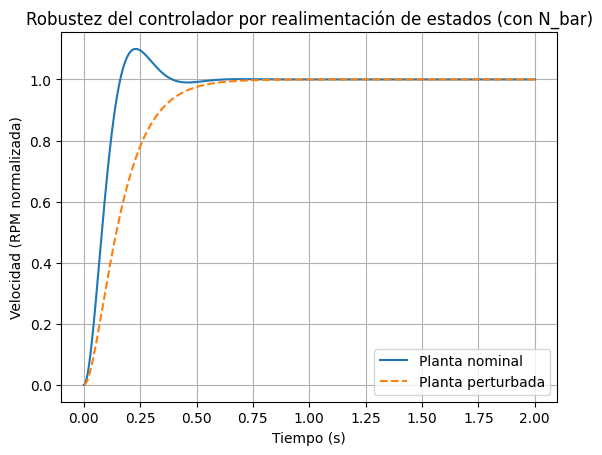

In [76]:

# --- Matrices del sistema nominal ---
A = np.array([[0, 1],
              [-wn**2, -2*zeta*wn]])

B = np.array([[0],
              [K * wn**2]])

C = np.array([[1, 0]])
D = np.array([[0]])

# --- Polos deseados (ya definidos) ---
p_deseados = [-10 + 13.64j, -10 - 13.64j]

# --- Ganancia por realimentación de estados ---
K_feedback = ctrl.place(A, B, p_deseados)

# --- Calcular N_bar para referencia unitaria ---
N_bar = -1.0 / (C @ np.linalg.inv(A - B @ K_feedback) @ B)
B_scaled = B * N_bar

# --- Sistema en lazo cerrado (nominal) ---
A_cl = A - B @ K_feedback
sys_nom = ctrl.ss(A_cl, B_scaled, C, D)

# --- Planta perturbada ---
wn_pert = wn * 0.7
zeta_pert = zeta * 1.2

A_pert = np.array([[0, 1],
                   [-wn_pert**2, -2*zeta_pert*wn_pert]])

B_pert = np.array([[0],
                   [K * wn_pert**2]])

# --- Recalcular N_bar para planta perturbada ---
N_bar_pert = -1.0 / (C @ np.linalg.inv(A_pert - B_pert @ K_feedback) @ B_pert)
B_pert_scaled = B_pert * N_bar_pert

# --- Sistema perturbado en lazo cerrado ---
A_cl_pert = A_pert - B_pert @ K_feedback
sys_pert = ctrl.ss(A_cl_pert, B_pert_scaled, C, D)

# --- Simulación de ambas respuestas ---
t = np.linspace(0, 2, 500)
t_nom, y_nom = ctrl.step_response(sys_nom, T=t)
t_pert, y_pert = ctrl.step_response(sys_pert, T=t)

# --- Gráfico comparativo ---
plt.plot(t_nom, y_nom, label='Planta nominal')
plt.plot(t_pert, y_pert, '--', label='Planta perturbada')
plt.title("Robustez del controlador por realimentación de estados (con N_bar)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (RPM normalizada)")
plt.grid(True)
plt.legend()
plt.show()


### Modelo en espacio de estados para posición

In [77]:
import numpy as np

# Parámetros identificados
K = 2084.9898
wn = 35.3737
zeta = 0.7204

# Matrices del sistema extendido (orden 3)
A_pos = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [0, -wn**2, -2*zeta*wn]
])

B_pos = np.array([[0], [0], [K * wn**2]])

C_pos = np.array([[1, 0, 0]])  # salida = posición
D_pos = np.array([[0]])


In [78]:
# Polos deseados para posición (más lentos y amortiguados)
p1 = -4 + 5j
p2 = -4 - 5j
p3 = -8     # real, más rápido para amortiguar

p_deseados_pos = [p1, p2, p3]


In [79]:
import control as ctrl

# Colocación de polos
K_pos = ctrl.place(A_pos, B_pos, p_deseados_pos)
print("Ganancia K para control de posición:")
print(K_pos)


Ganancia K para control de posición:
[[ 1.25721320e-04 -4.39372499e-04 -1.34025163e-05]]


In [80]:
# Precompensación N_bar para r(t) = 1
N_bar_pos = -1.0 / (C_pos @ np.linalg.inv(A_pos - B_pos @ K_pos) @ B_pos)
B_pos_scaled = B_pos * N_bar_pos


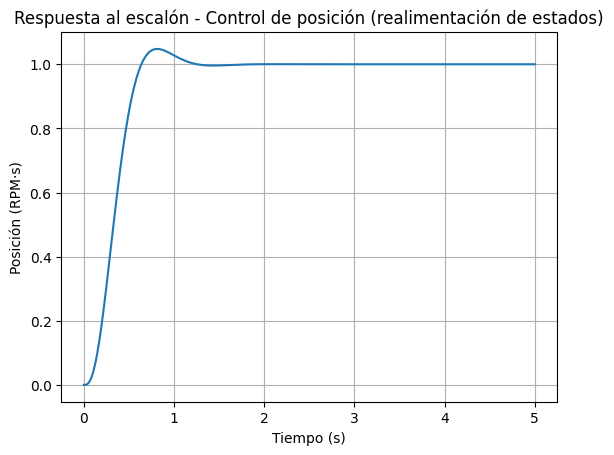

In [81]:
# Sistema en lazo cerrado
A_cl_pos = A_pos - B_pos @ K_pos
sys_pos = ctrl.ss(A_cl_pos, B_pos_scaled, C_pos, D_pos)

# Simular respuesta al escalón (posición)
import matplotlib.pyplot as plt

t = np.linspace(0, 5, 500)
t_out, y_out = ctrl.step_response(sys_pos, T=t)

plt.plot(t_out, y_out)
plt.title("Respuesta al escalón - Control de posición (realimentación de estados)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (RPM·s)")
plt.grid(True)
plt.show()


### Controlador adelanto–atraso para posición angular

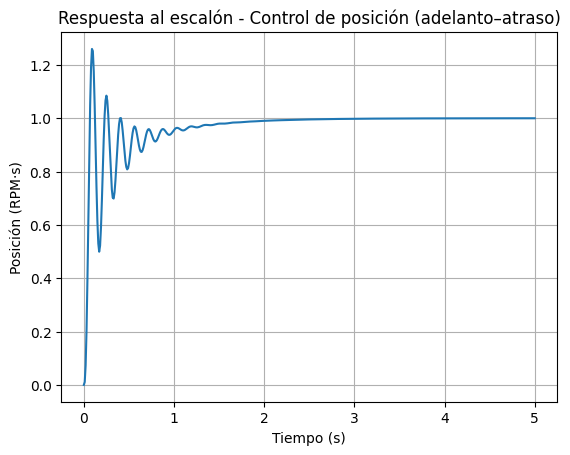

In [88]:
import control as ctrl
import matplotlib.pyplot as plt
import numpy as np

# Parámetros identificados
K = 2084.9898
wn = 35.3737
zeta = 0.7204

# Planta en posición: G(s)/s
num_theta = [K * wn**2]
den_theta = [1, 2*zeta*wn, wn**2, 0]  # se agrega s en el denominador
G_theta = ctrl.TransferFunction(num_theta, den_theta)

z = 2       # cero del compensador
p = 20      # polo del compensador
Kc = 0.03  # ganancia inicial baja por la alta ganancia de la planta
C_pos = ctrl.TransferFunction([1, z], [1, p])

# Sistema en lazo abierto
L_pos = Kc * C_pos * G_theta

# Lazo cerrado unitario
T_pos = ctrl.feedback(L_pos)

# Simulación
t = np.linspace(0, 5, 500)
t_out, y_out = ctrl.step_response(T_pos, T=t)

plt.plot(t_out, y_out)
plt.title("Respuesta al escalón - Control de posición (adelanto–atraso)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (RPM·s)")
plt.grid(True)
plt.show()


## Implementacion En entorno real

### Discretizar Adelanto Atrazo

In [90]:
from control import TransferFunction as tf, sample_system
Ts = 0.01  # periodo de muestreo (s)

# Controlador continuo
C = tf([Kc, Kc*z], [1, p])
# Discretización bilineal (Tustin)
Cd = sample_system(C, Ts, method='tustin')
print("Controlador discreto Cd(z):")
print(Cd)

b = Cd.num[0][0]
a = Cd.den[0][0]
print(f"Coeficientes: b = {b}, a = {a}")


Controlador discreto Cd(z):
<TransferFunction>: sys[146]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.02755 z - 0.027
-----------------
   z - 0.8182

dt = 0.01

Coeficientes: b = [ 0.02754545 -0.027     ], a = [ 1.         -0.81818182]


In [96]:
import serial
import time
import csv
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# === CONFIGURACIÓN SERIAL Y CONTROLADOR ===
PORT = 'COM7'
BAUD = 115200
Ts = 0.01
DURATION = 5  # duración total de la prueba

# Controlador discretizado
b0 = 0.02754545
b1 = -0.027
a1 = -0.81818182
referencia = 1000.0

e = e_prev = u = u_prev = 0
angulo_prev = None
t_prev = None

# === Variables para animación ===
tiempos = []
rpms = []

# Serial
ser = serial.Serial(PORT, BAUD, timeout=1)
time.sleep(2)
start_time = time.time()
absolute_start_time = start_time

# CSV
CSV_FILENAME = "control_velocidad_rpm_animacion.csv"
f = open(CSV_FILENAME, mode='w', newline='')
writer = csv.writer(f)
writer.writerow(['timestamp', 'angle', 'rpm', 'pwm'])

# === Gráfica en tiempo real ===
fig, ax = plt.subplots()
line, = ax.plot([], [], label='RPM')
ax.set_xlim(0, DURATION)
ax.set_ylim(0, 1500)
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Velocidad (RPM)")
ax.set_title("RPM del motor en tiempo real")
ax.legend()

def init():
    line.set_data([], [])
    return line,

def update(frame):
    global e, e_prev, u, u_prev, angulo_prev, t_prev

    current_time = time.time()
    elapsed = current_time - start_time

    if elapsed > DURATION:
        ser.write(b"0\n")
        return line,

    try:
        line_raw = ser.readline().decode().strip()
        angle = float(line_raw)
        timestamp = current_time

        if (timestamp - absolute_start_time < 0.5):
            angulo_prev = angle
            t_prev = timestamp
            return line,

        dt = timestamp - t_prev
        delta = (angle - angulo_prev) % 360
        if delta > 180:
            delta -= 360
        rpm_actual = (delta / dt) * (60 / 360)

        # Controlador discreto
        e = referencia - rpm_actual
        u = b0 * e + b1 * e_prev - a1 * u_prev
        pwm = max(min(u, 100), -100)

        # Enviar PWM
        ser.write(f"{int(pwm)}\n".encode())

        # Guardar
        writer.writerow([timestamp, angle, rpm_actual, pwm])
        print(f"{elapsed:.2f}s | RPM: {rpm_actual:.2f} | PWM: {pwm:.2f}")

        # Graficar
        tiempos.append(elapsed)
        rpms.append(rpm_actual)
        line.set_data(tiempos, rpms)

        # Actualizar control
        angulo_prev = angle
        t_prev = timestamp
        e_prev = e
        u_prev = u

        ax.set_xlim(0, max(DURATION, elapsed + 0.1))
        ax.set_ylim(0, max(rpm_actual + 50, 200))

        time.sleep(Ts)
        return line,

    except:
        return line,

# Iniciar animación
ani = FuncAnimation(fig, update, init_func=init, blit=True, interval=10)
plt.show()

# Finalizar
ser.close()
f.close()
print(f"Datos guardados en {CSV_FILENAME}")


SerialException: could not open port 'COM7': PermissionError(13, 'Acceso denegado.', None, 5)